In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nozzle import Spectral, Params, Nozzle, Boundary
from scipy.integrate import simpson

# Linear elements
Let $ \tilde{v}(x) = \sum_{j=1}^{N} c_ju_j(x) $ where $u_j(x)$ are tent functions that peaks at $x_j\in(-1,1)$.

## fixed ends

<AxesSubplot:xlabel='$z$', ylabel='$\\tilde{v}$'>

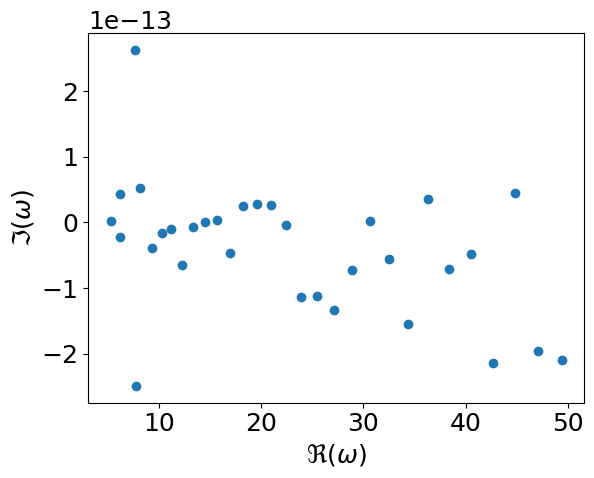

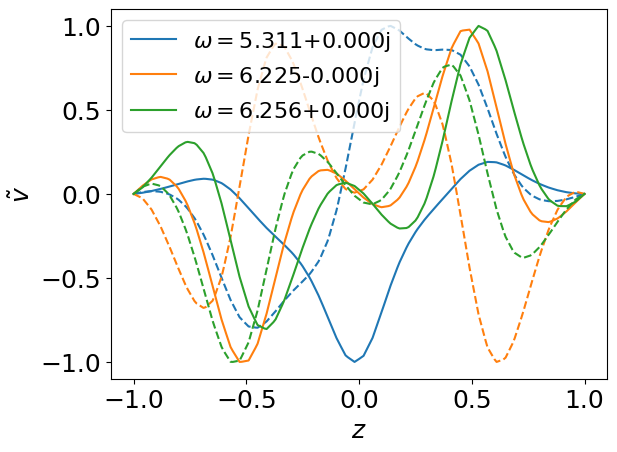

In [42]:
N = 50 # number of tent functions
M = 201 # number of points
Mm = 0.5
constant_v = True
accelerating = False
params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

dx = 2/(N+1)
node = np.linspace(-1+dx,1-dx,N)

u = lambda x,n: np.piecewise(x, [np.abs(x-node[n])/dx<=1], [lambda x: -np.abs(x-node[n])/dx+1, 0])

nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(N):
    for j in range(N):
        if np.abs(i-j)<=1:
            A2[i,j] = simpson(u(x,i)*u(x,j),x)
            A1[i,j] = 2j*simpson(u(x,i)*v0*(D1@u(x,j)) + u(x,i)*(D1@v0)*u(x,j),x)
            A0[i,j] = simpson(
                u(x,i)*(1-v0**2)*(D2@u(x,j)) -
                # -D1@(u(x,i)*(1-v0**2))*(D1@u(x,j)) -
                u(x,i)*(3*v0+1/v0)*(D1@v0)*(D1@u(x,j)) - 
                u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
                u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
                x)

nozzle.solve(A0,A1,A2)
nozzle.sort_solutions(real_range=[0.1,50], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=3)
# nozzle.save_data("FE_Tent", N=N)

# Cubic B Spline
Let $ \tilde{v} = \sum_{n=0}^{N} c_nP_n(x) $, where $P_n(x)$ are cubic B spline.

Text(0, 0.5, 'B-Spline')

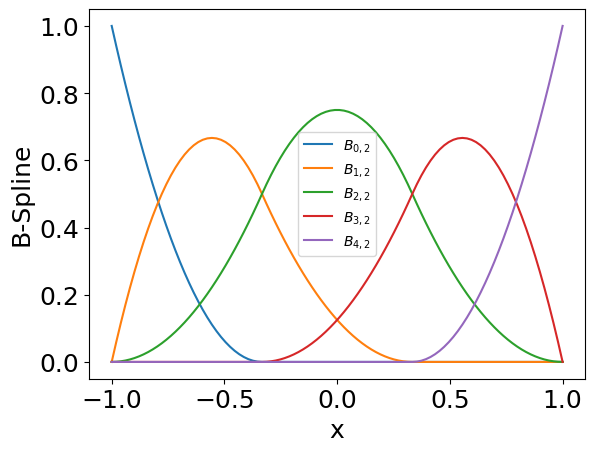

In [42]:
from scipy.interpolate import BSpline
x = np.linspace(-1,1,100)
N = 5 # number basis functions
k = 2 # polynomial degree
t = np.concatenate([-np.ones(k), np.linspace(-1,1,N-k+1) ,np.ones(k)]) # knot vector
c = np.zeros(t.size-k-1) # coefficients
c[-1] = 1
for i in range(t.size-k-1):
    c = np.roll(c,1)
    spline = BSpline(t,c,k)
    plt.plot(x,spline(x), label="$B_{%d,%d}$"%(i,k))
plt.legend(fontsize="medium")
plt.xlabel("x")
plt.ylabel("B-Spline")

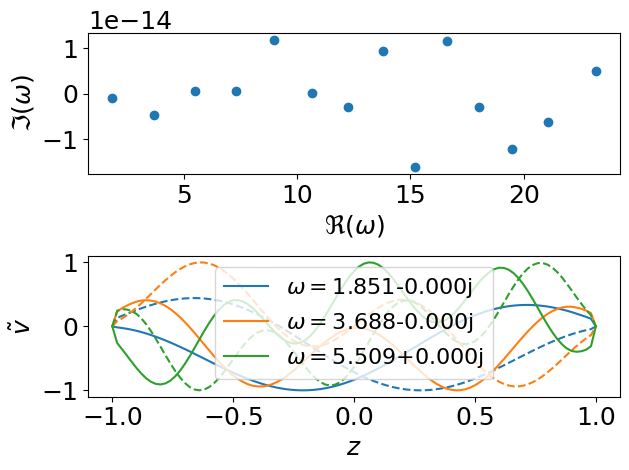

In [39]:
M = 101 # number of points
k = 2 # degree of b-spline
N = 50 # number of basis function
t = np.concatenate([-np.ones(k), np.linspace(-1,1,N-k+1) ,np.ones(k)]) # knot vector
u = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k)(x) # basis functions
u_p = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative()(x) # basis functions
u_pp = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative(2)(x) # basis functions

Mm = 1.5
constant_v = True
accelerating = False
params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2


nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

A2 = np.zeros((N,N), dtype=complex) # n from -1 to N+1
A1 = np.zeros((N,N), dtype=complex)
A0 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        if np.abs(i-j) <= 3:
            A2[i,j] = simpson(u(x,i)*u(x,j),x)
            A1[i,j] = 2j*simpson(u(x,i)*v0*u_p(x,j) + u(x,i)*(D1@v0)*u(x,j),x)
            A0[i,j] = simpson(
                # u(x,i)*(1-v0**2)*u_pp(x,j) -
                -D1@(u(x,i)*(1-v0**2))*u_p(x,j) -
                u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,j) - 
                u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
                u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
                x)

nozzle.solve(A0,A1,A2)
nozzle.sort_solutions(real_range=[0,25], imag_range=[-1,1])

fig, ax = plt.subplots(2,1)
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=3,ax=ax[1])
plt.tight_layout()
nozzle.save_data("FE", N=N)

In [37]:
exact = np.arange(1,10)*np.pi/2*np.abs(1-Mm**2)
omega = nozzle.omega

size = min(exact.size, omega.size)
rel_err = np.abs(omega[:size]-exact[:size])/exact[:size]
rel_err

array([0.00352322, 0.00260397, 0.0015463 , 0.00037059, 0.00240529,
       0.00535026, 0.00843983, 0.01162732, 0.01656876])